In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Install nam & shap library
!pip install git+https://github.com/lemeln/nam.git
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lemeln/nam.git to /tmp/pip-req-build-xd6elr6q
  Running command git clone --filter=blob:none --quiet https://github.com/lemeln/nam.git /tmp/pip-req-build-xd6elr6q
  Resolved https://github.com/lemeln/nam.git to commit 41aa391513d2c9168003291174113a6e3bd17e85
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.1 MB/s eta 0:00:00
  Created wheel for nam-interpret: filename=nam_interpret-0.0.0-py3-none-any.whl size=19429 sha256=7793a474ee310b9c1f01905be49495da8801559adfa05b8b29330547c3467d65
  Stored in directory: /tmp/pip-ephem-wheel-cache-ca_fad5_/wheels/cc/00/f5/592e1e5dd86b71fc3cbba355e6de265800ea70f4796498c7cd
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=db566cc03e2abcc42e0bdc2af4de3f689c784f1984e35c8893817114a1dccdfe
  Stor

In [3]:
#@title Import libraries
import numpy as np
import pandas as pd
import shap
shap.initjs()

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix
from nam.wrapper import NAMClassifier

In [4]:
#@title Load datasets
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_split.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_val_split.csv')

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             184 non-null    int64  
 1   Sex             184 non-null    object 
 2   ChestPainType   184 non-null    object 
 3   RestingBP       184 non-null    int64  
 4   Cholesterol     184 non-null    int64  
 5   FastingBS       184 non-null    int64  
 6   RestingECG      184 non-null    object 
 7   MaxHR           184 non-null    int64  
 8   ExerciseAngina  184 non-null    object 
 9   Oldpeak         184 non-null    float64
 10  ST_Slope        184 non-null    object 
 11  HeartDisease    184 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 17.4+ KB


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 68.9+ KB


In [7]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,734.0,53.523161,9.421110,29.0,47.00,54.0,60.0,77.0
RestingBP,734.0,132.062670,18.618490,0.0,120.00,130.0,140.0,200.0
Cholesterol,734.0,197.588556,108.979439,0.0,172.25,222.0,267.0,529.0
FastingBS,734.0,0.232970,0.423012,0.0,0.00,0.0,0.0,1.0
MaxHR,734.0,136.167575,25.334552,60.0,120.00,138.0,155.0,195.0
Oldpeak,734.0,0.873978,1.082222,-2.0,0.00,0.5,1.5,6.2
HeartDisease,734.0,0.542234,0.498553,0.0,0.00,1.0,1.0,1.0


In [8]:
train_data.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


# Preprocessing

In [9]:
#@title One Hot Encoding
train_data_ohe = pd.get_dummies(train_data)
test_data_ohe = pd.get_dummies(test_data)
train_data_ohe.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
2,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
3,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1
4,39,120,339,0,170,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [10]:
#@title Split features and lables
y_train = train_data_ohe.HeartDisease
x_train_pre = train_data_ohe.drop(['HeartDisease'], axis = 1)

y_test = test_data_ohe.HeartDisease
x_test_pre = test_data_ohe.drop(['HeartDisease'], axis = 1)

In [11]:
#@title Standardization
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_pre)
x_train = pd.DataFrame(x_train, columns=x_train_pre.columns)

x_test = scaler.fit_transform(x_test_pre)
x_test = pd.DataFrame(x_test, columns=x_test_pre.columns)

x_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.436389,0.426605,0.839367,-0.551117,1.415334,-0.808128,-0.530073,0.530073,-1.038903,1.964924,-0.546914,-0.216969,-0.504679,0.817424,-0.496165,0.819745,-0.819745,-0.26452,-0.991859,1.131151
1,-1.755040,-0.110862,0.784273,-0.551117,-1.507570,-0.808128,-0.530073,0.530073,-1.038903,1.964924,-0.546914,-0.216969,-0.504679,-1.223355,2.015458,0.819745,-0.819745,-0.26452,-0.991859,1.131151
2,-0.586654,0.319112,0.150695,-0.551117,-1.112583,0.578854,1.886533,-1.886533,0.962553,-0.508925,-0.546914,-0.216969,-0.504679,0.817424,-0.496165,-1.219892,1.219892,-0.26452,1.008208,-0.884055
3,0.050648,0.964072,-0.023769,-0.551117,-0.559601,-0.808128,-0.530073,0.530073,-1.038903,-0.508925,1.828441,-0.216969,-0.504679,0.817424,-0.496165,0.819745,-0.819745,-0.26452,-0.991859,1.131151
4,-1.542606,-0.648328,1.298482,-0.551117,1.336337,-0.808128,-0.530073,0.530073,-1.038903,-0.508925,1.828441,-0.216969,-0.504679,0.817424,-0.496165,0.819745,-0.819745,-0.26452,-0.991859,1.131151


# Single Task NAMs Classification

In [12]:
#@title Build NAM Classifier
model = NAMClassifier(
            hidden_sizes=[64, 32],
            batch_size=64,
            num_epochs=10,
            num_learners=20,
            metric='auroc',
            early_stop_mode='max',
            monitor_loss=True,
            n_jobs=5
        )

In [13]:
#@title Train Model
model.fit(x_train, y_train)

# Model Evalutation

In [14]:
#@title Prediction on test set
pred = model.predict(x_test)
pred_proba = model.predict_proba(x_test)

In [15]:
#@title Performance metrics
print("Accuracy of NAM Classifier: {}".format(accuracy_score(y_test, pred)))
print("Balanced Accuracy of NAM Classifier: {}".format(balanced_accuracy_score(y_test, pred)))
print("F1-Score of NAM Classifier: {}".format(f1_score(y_test, pred)))
print("Confusion Matrix of NAM Classifier:\n {}".format(confusion_matrix(y_test, pred)))

Accuracy of NAM Classifier: 0.8369565217391305
Balanced Accuracy of NAM Classifier: 0.826044226044226
F1-Score of NAM Classifier: 0.8660714285714286
Confusion Matrix of NAM Classifier:
 [[57 17]
 [13 97]]


# Visualization of Feature Importance

In [16]:
#@title Shap Permutation Explainer
explainer = shap.explainers.Permutation(model.predict_proba, x_train)
shap_values = explainer(x_test)

Permutation explainer: 185it [22:36,  7.37s/it]


## Feature Importance of overall model

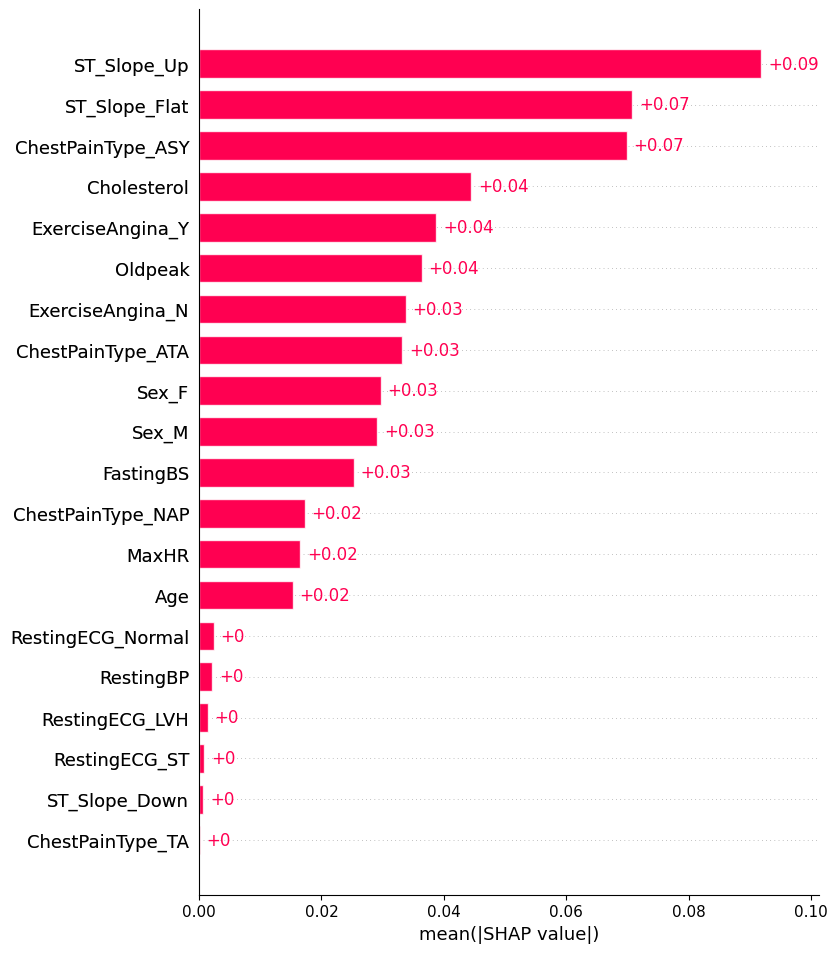

In [17]:
shap.plots.bar(shap_values, max_display=20)

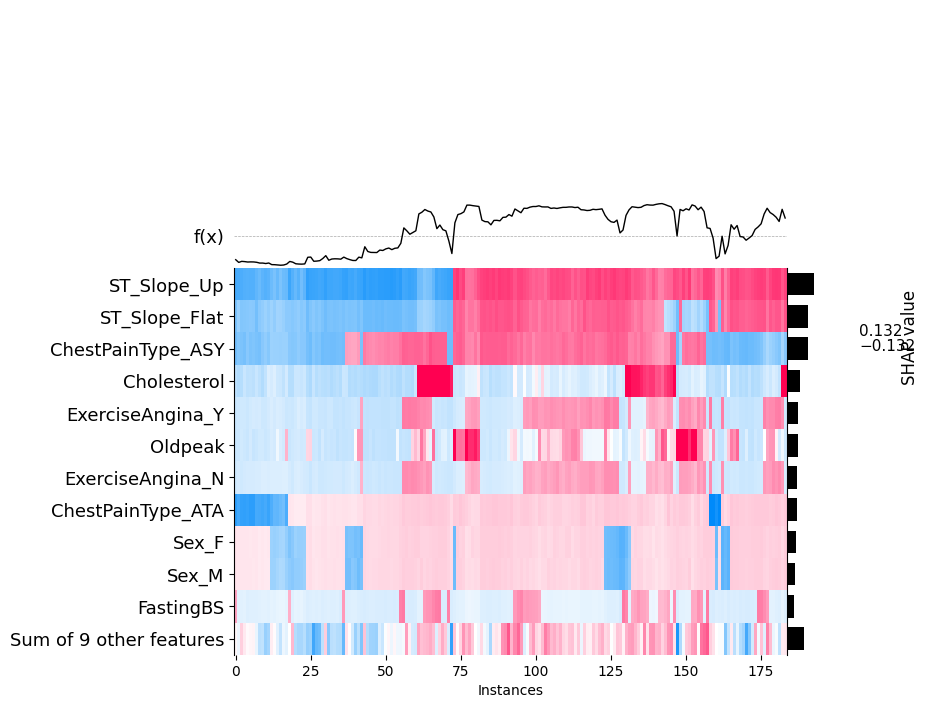

In [18]:
shap.plots.heatmap(shap_values, max_display=12)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


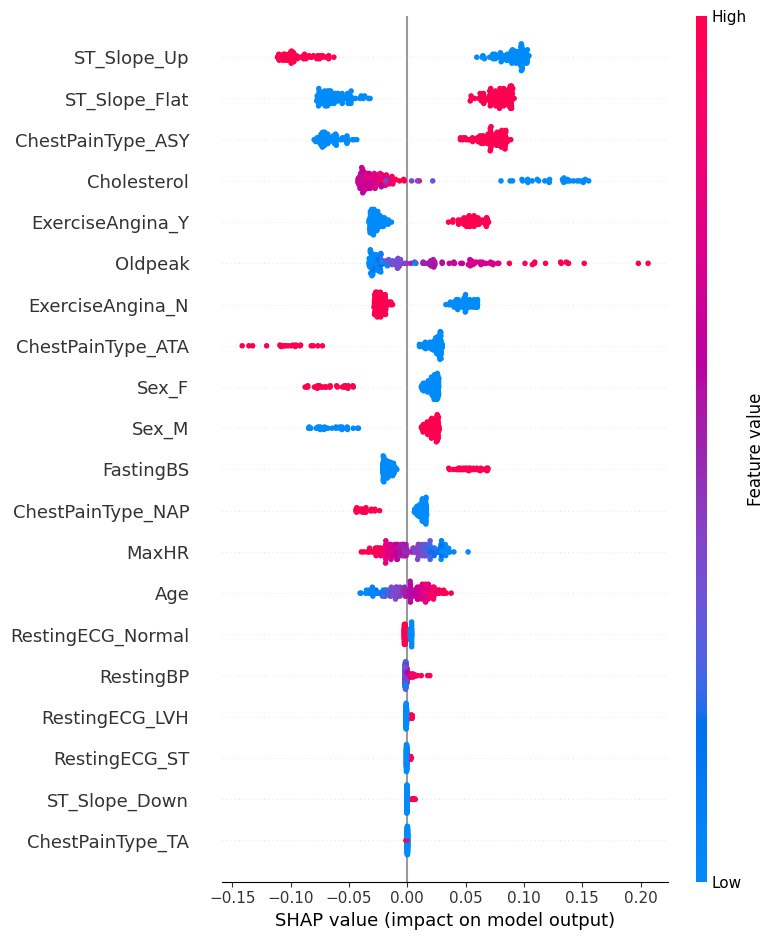

In [19]:
shap.summary_plot(shap_values)

## Feature Importance of four positive samples

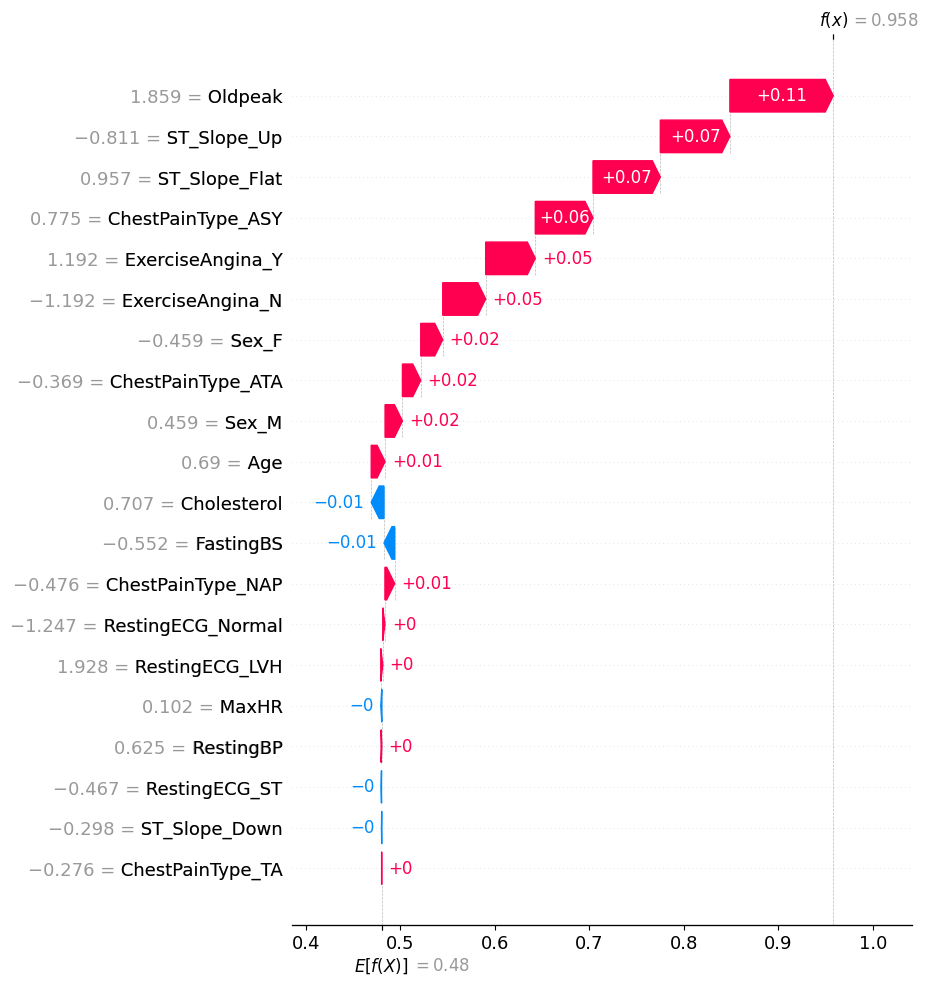

In [20]:
shap.plots.waterfall(shap_values[0], max_display=20)

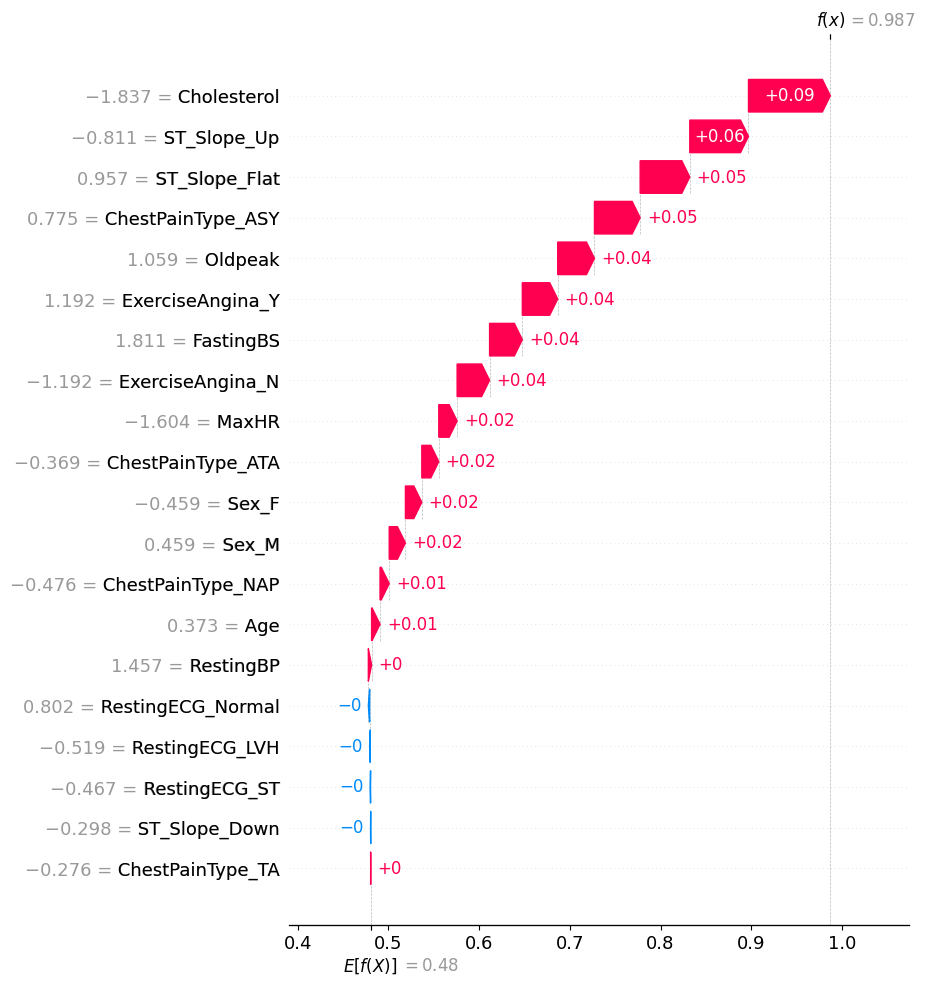

In [21]:
shap.plots.waterfall(shap_values[1], max_display=20)

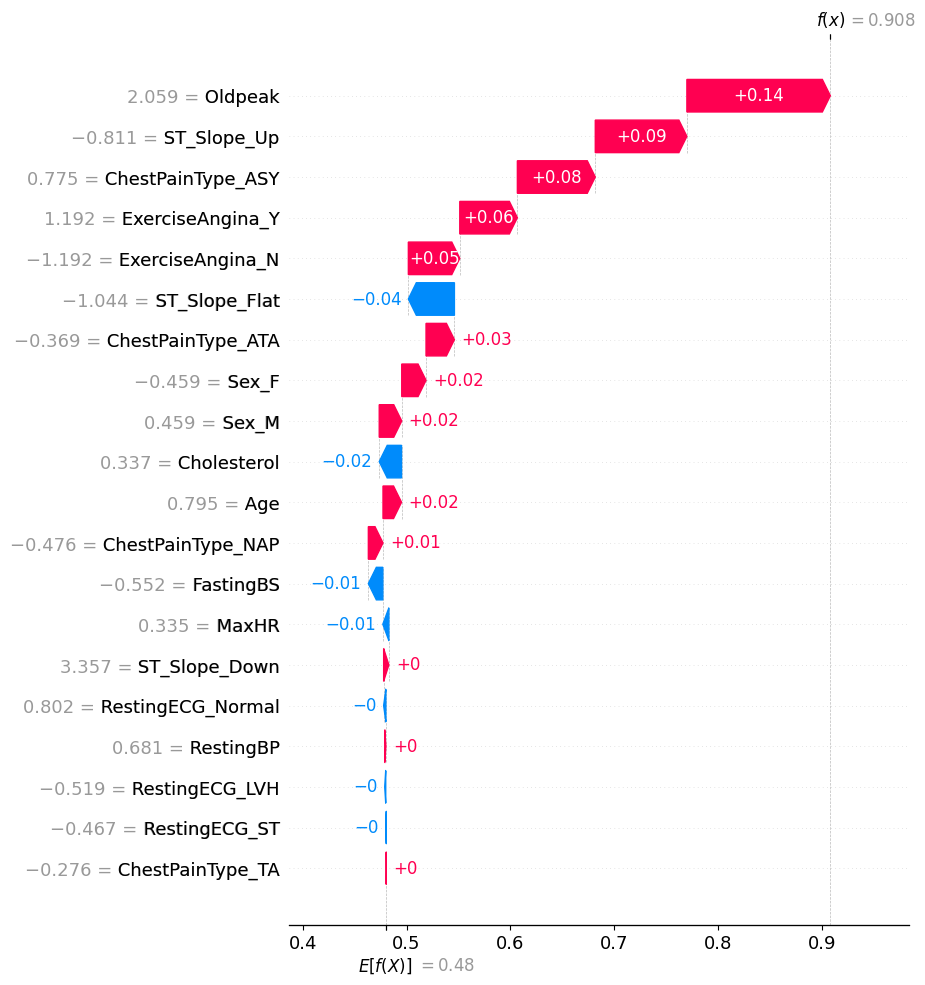

In [25]:
shap.plots.waterfall(shap_values[8], max_display=20)

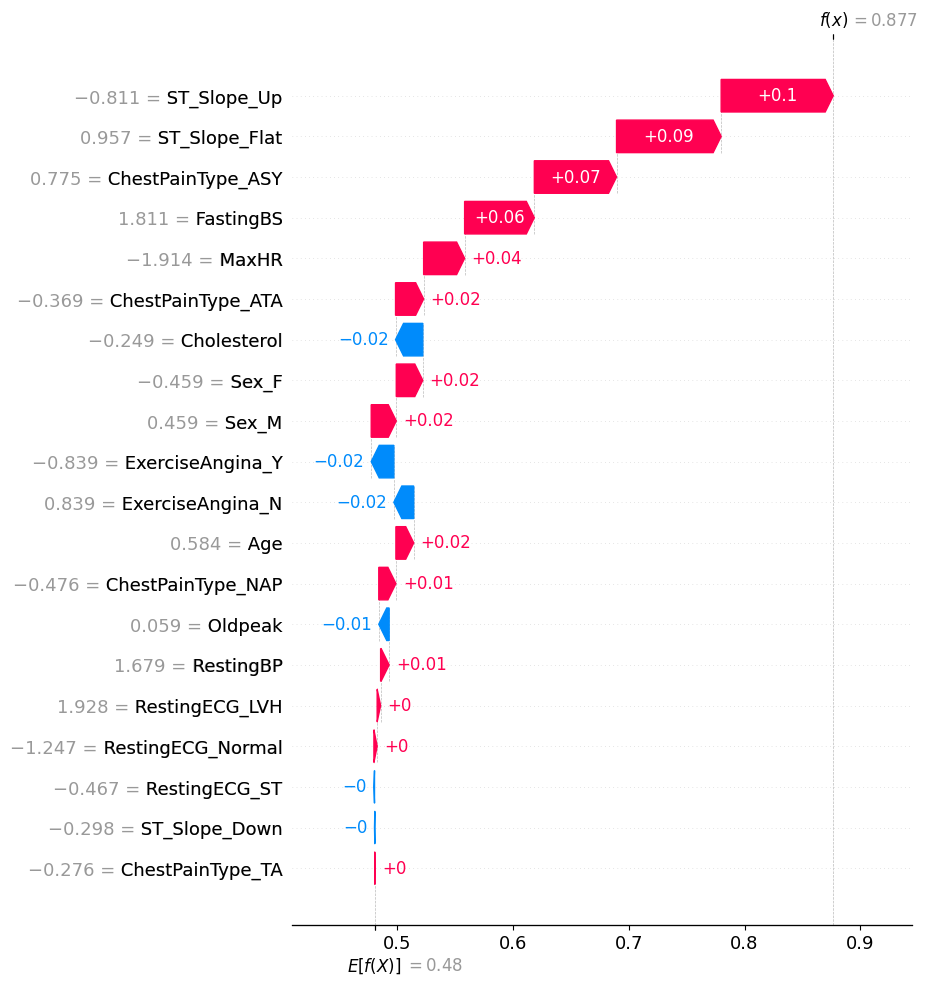

In [26]:
shap.plots.waterfall(shap_values[3], max_display=20)

## Feature Importance on four negative samples

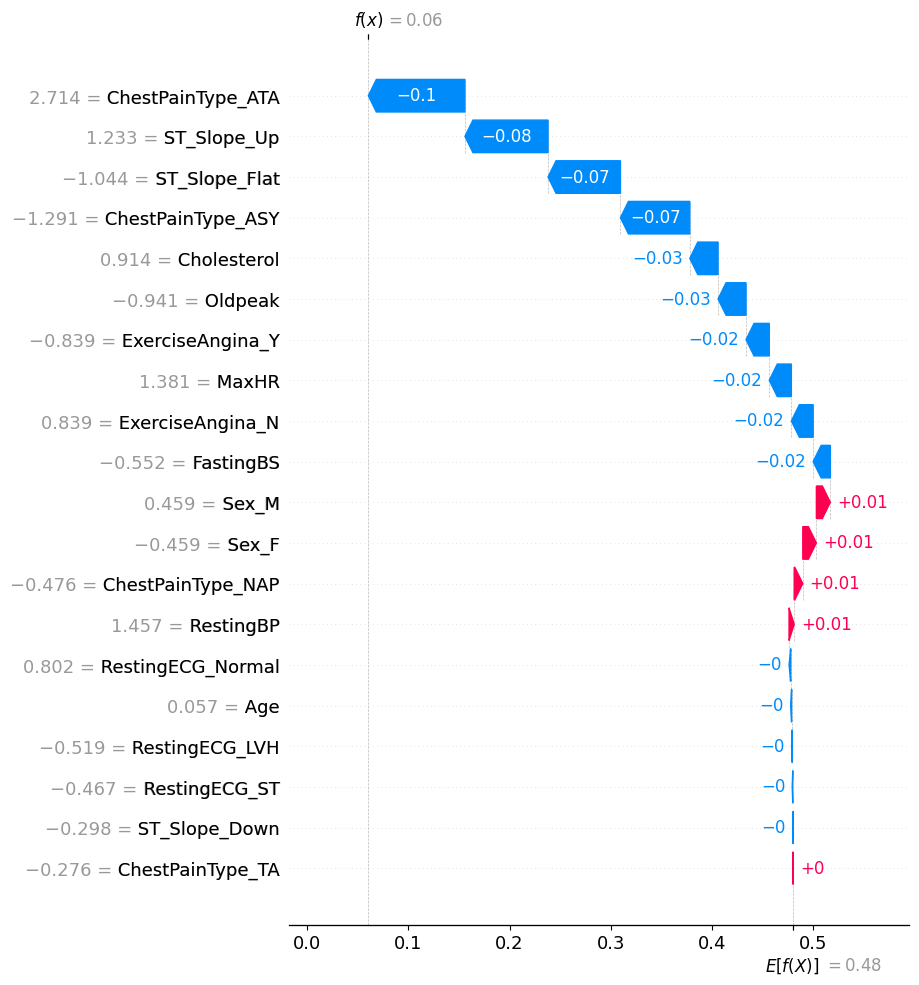

In [27]:
shap.plots.waterfall(shap_values[6], max_display=20)

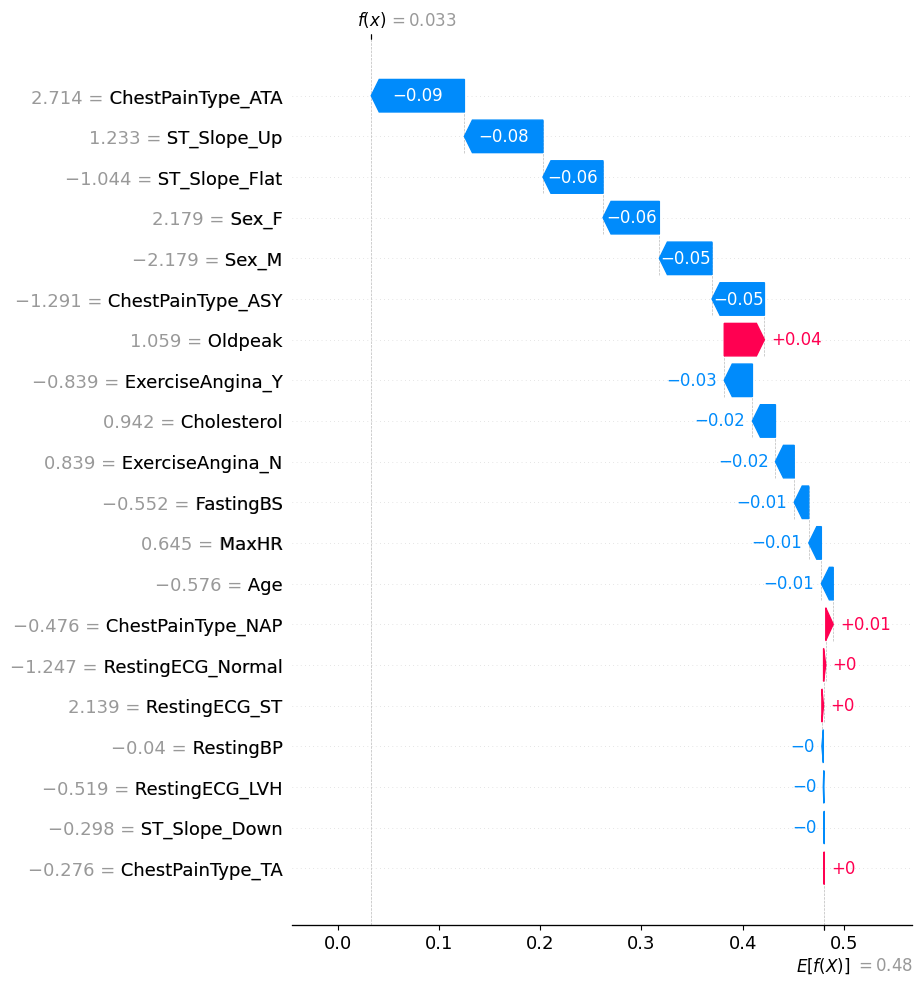

In [28]:
shap.plots.waterfall(shap_values[19], max_display=20)

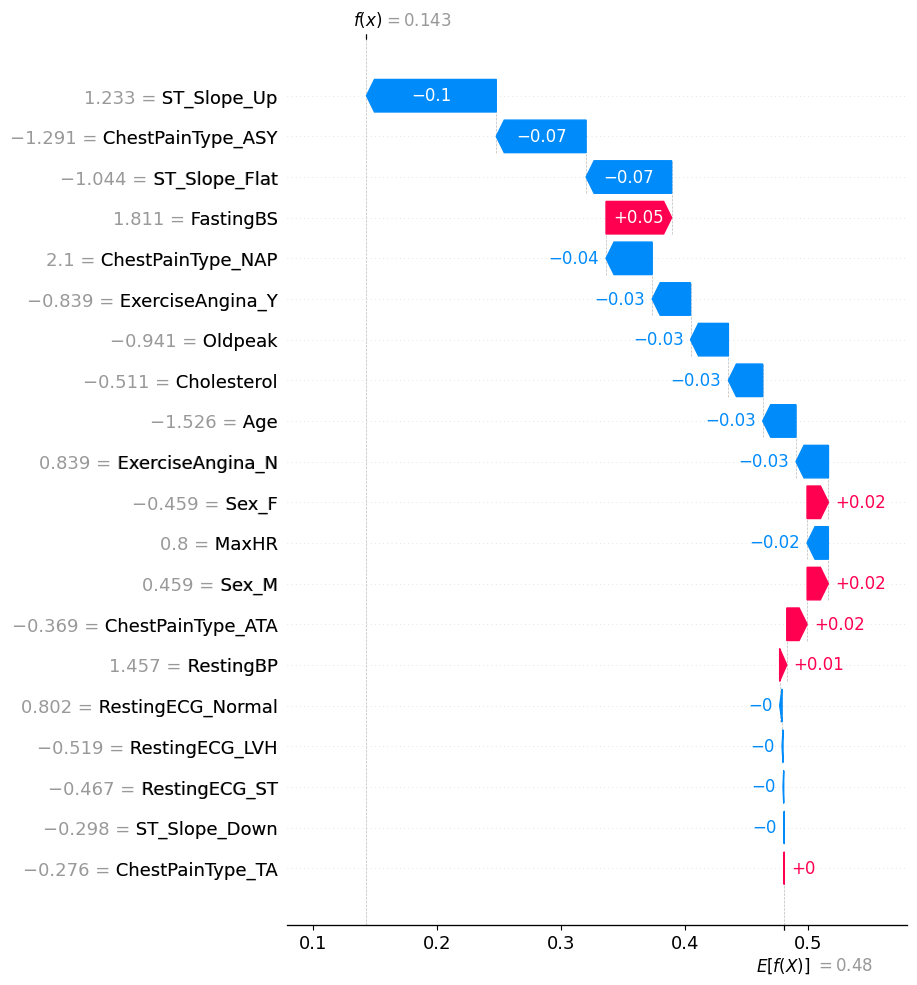

In [29]:
shap.plots.waterfall(shap_values[22], max_display=20)

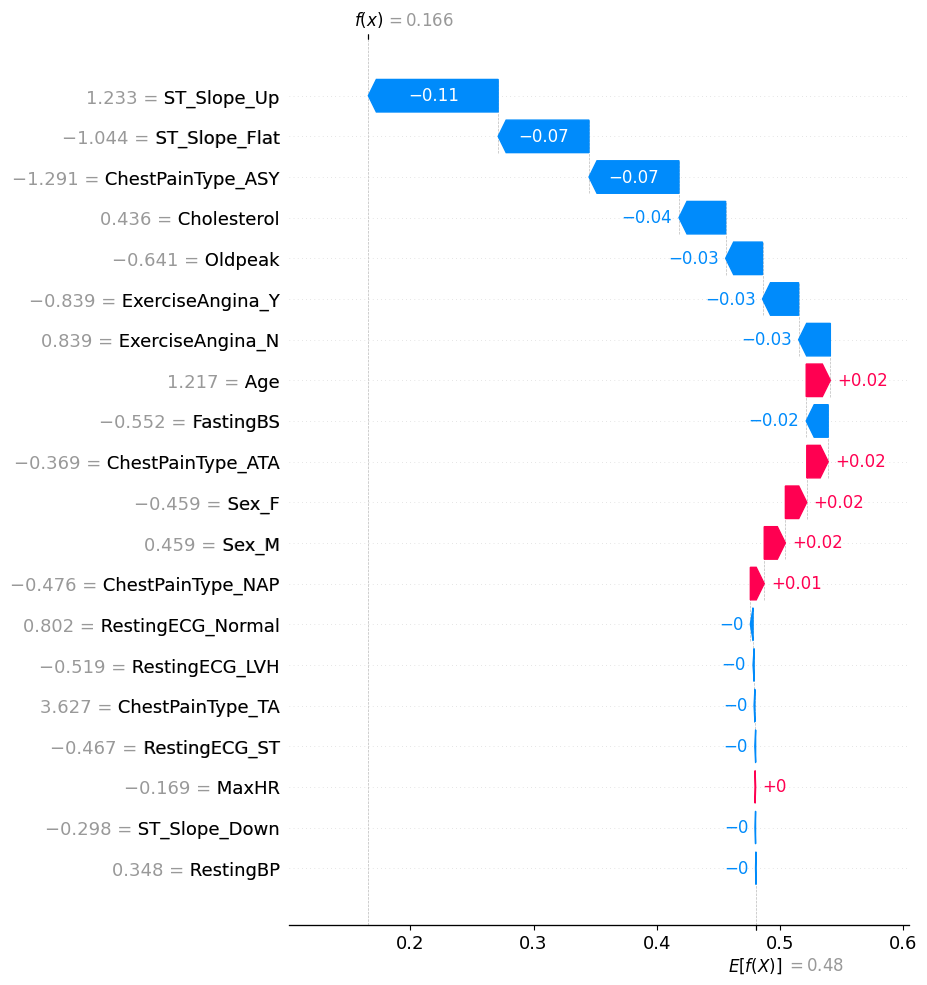

In [30]:
shap.plots.waterfall(shap_values[13], max_display=20)